In [1018]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [1019]:
from google.colab import drive
drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1020]:
def label_count(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [1021]:
def prepare_data(ticker):
    base_path = "/content/drive/My Drive"
    stock_price = pd.read_csv(f"{base_path}/dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()

    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    stock_price['200_ma'] = stock_price['prv_close'].rolling(window=200, min_periods=1).mean()
    stock_price['50_ma'] = stock_price['prv_close'].rolling(window=50, min_periods=1).mean()

    stock_news = pd.read_csv(f"{base_path}/dataset/polygon_title_sentiment_3/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date

    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = 0.0
    stock_news['pos_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_score'] = 0.0
    stock_news['neg_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_mean'] = np.nan
    stock_news['pos_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_mean'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    df_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [label_count(['positive']), label_count(['negative'])], '200_ma': 'first', '50_ma': 'first',
        'sentiment_score': 'mean', 'pos_score': 'mean', 'neg_score': 'mean', 'pos_mean': 'mean', 'neg_mean': 'mean'
    }).fillna(0.0).reset_index()
    df_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative',
                           '200_ma', '50_ma', 'all_score', 'pos_score', 'neg_score', 'pos_mean', 'neg_mean']
    return df_gp

In [1022]:
tickers = ['AAPL', 'GOOGL', 'MSFT', 'META', 'AMZN']
ticker = tickers[4]
df_gp = prepare_data(ticker)
df_gp

<ipython-input-1020-cc6a419d00d3>:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


,trade_date,prv_close,delta,close,open,high,low,positive,negative,200_ma,50_ma,all_score,pos_score,neg_score,pos_mean,neg_mean
0,2022-10-31,0.00,0.00,102.44,103.560,104.8700,100.740,0.294118,0.235294,0.000000,0.000000,0.044923,0.229039,-0.184116,0.778732,-0.782492
1,2022-11-01,102.44,-5.65,96.79,103.990,104.5800,96.060,0.206897,0.310345,102.440000,102.440000,-0.073781,0.169824,-0.243604,0.820814,-0.784948
2,2022-11-02,96.79,-4.67,92.12,97.315,97.7400,92.010,0.238095,0.380952,99.615000,99.615000,-0.150809,0.211836,-0.362645,0.889713,-0.951943
3,2022-11-03,92.12,-2.82,89.30,92.470,93.5000,89.020,0.157895,0.315789,97.116667,97.116667,-0.152280,0.110308,-0.262588,0.698619,-0.831529
4,2022-11-04,89.30,1.68,90.98,91.490,92.4400,88.040,0.222222,0.444444,95.162500,95.162500,-0.206518,0.152944,-0.359463,0.688250,-0.808791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-10-23,189.70,-4.99,184.71,188.850,189.1600,183.690,0.285714,0.142857,179.123625,182.653000,0.104629,0.240949,-0.136320,0.843320,-0.954241
498,2024-10-24,184.71,1.67,186.38,185.250,187.1100,183.860,0.333333,0.333333,179.301675,182.942600,-0.147875,0.172377,-0.320252,0.517131,-0.960757
499,2024-10-25,186.38,1.45,187.83,187.850,190.4500,187.530,0.833333,0.000000,179.476725,183.268200,0.666995,0.666995,0.000000,0.800394,0.000000
500,2024-10-28,187.83,0.56,188.39,189.565,190.2100,188.210,0.666667,0.000000,179.647225,183.473000,0.457286,0.457286,0.000000,0.685930,0.000000


In [1023]:
def test_relevance(cols):
    X, y = df_gp[cols], df_gp['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    r2 = r2_score(y, y_pred)
    corr = [np.corrcoef(X[col], y)[0, 1] for col in X]

    return corr, r2, model.coef_

In [1024]:
test_relevance(['negative'])

([-0.1112234818670413], 0.012370662918628095, array([-2.2218649]))

In [1025]:
test_relevance(['pos_score'])

([0.09275769809199166], 0.008603990555325125, array([1.85164684]))

In [1026]:
test_relevance(['neg_score'])

([0.11807827641299153], 0.01394247936066284, array([2.66774739]))

In [1027]:
test_relevance(['pos_score', 'neg_score'])

([0.09275769809199166, 0.11807827641299153],
 0.016207990413158013,
 array([1.04679538, 2.17053232]))

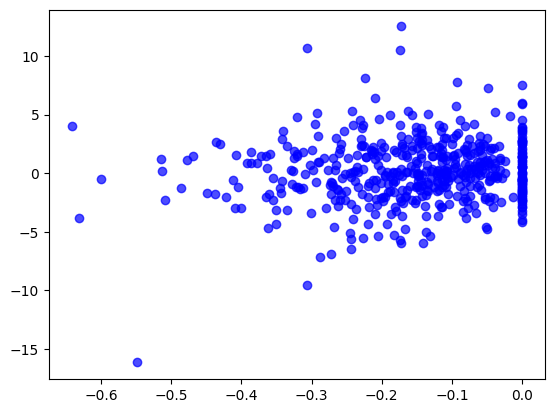

In [1028]:
import matplotlib.pyplot as plt

plt.scatter(df_gp['neg_score'], df_gp['delta'], color='blue', alpha=0.7)

In [1029]:
def preprocess(df_gp, feat_cols, seq_length=50, offset=0):
    std_scaler = StandardScaler()
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(df_gp[feat_cols])

    X = []
    y = []
    st = seq_length + offset
    for i in range(st, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = torch.tensor(np.array(X), dtype=torch.float32).to(device)
    y = torch.tensor(np.array(y), dtype=torch.float32).unsqueeze(1).to(device)

    split_index = int(len(X) * 0.95)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05)

    return X, y, X_train, X_val, X_test, y_train, y_val, y_test, st

In [1030]:
class SimpleLSTM(nn.Module):
    def __init__(self, feat_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.fc1 = nn.Linear(feat_size[0], feat_size[1])
        self.lstm = nn.LSTM(feat_size[1], feat_size[2], num_layers=layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(feat_size[2], feat_size[3])

    def forward(self, x):
        inp = self.fc1(x)
        lstm_out, (hn, cn) = self.lstm(inp)
        out = self.fc2(hn[-1])
        return out

In [1031]:
feat_dict = {
    'AAPL': ['neg_score', 'prv_close', '50_ma', 'delta'],
    'GOOGL': ['neg_score', 'prv_close', '50_ma', 'delta'],
    'other': ['neg_score', 'prv_close', 'delta'],
}
epoch_dict = {
    'other': 1000,
}

In [1032]:
feat_cols = feat_dict[ticker] if ticker in feat_dict else feat_dict['other']
X, y, X_train, X_val, X_test, y_train, y_val, y_test, st = preprocess(df_gp, feat_cols)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape, st

(torch.Size([407, 50, 3]),
 torch.Size([22, 50, 3]),
 torch.Size([23, 50, 3]),
 torch.Size([407, 1]),
 torch.Size([22, 1]),
 torch.Size([23, 1]),
 50)

In [1033]:
def split_set(X, y, deltas, num=20, ratio=0.05):
    X_list = []
    y_list = []
    y_stat = []
    for i in range(num):
        X_train, y_train = [], []
        X_test, y_test = [], []
        y_ref = []
        for j in range(X.shape[0]):
            if j % num != i:
                X_train.append(X[j].cpu().numpy())
                y_train.append(y[j].cpu().numpy())
                y_ref.append(deltas[j])
            else:
                X_test.append(X[j].cpu().numpy())
                y_test.append(y[j].cpu().numpy())

        X_train, X_test = np.array(X_train), np.array(X_test)
        y_train, y_test = np.array(y_train), np.array(y_test)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=ratio)

        X_list.append((
            torch.tensor(X_train).to(device),
            torch.tensor(X_val).to(device),
            torch.tensor(X_test).to(device),
        ))
        y_list.append((
            torch.tensor(y_train).to(device),
            torch.tensor(y_val).to(device),
            torch.tensor(y_test).to(device),
        ))
        y_stat.append((np.mean(y_ref), np.std(y_ref)))
    print(f"train size:{X_list[0][0].shape}, val size: {X_list[0][1].shape}, test size: {X_list[0][2].shape}")
    return X_list, y_list, y_stat

In [1034]:
def train(X_train, X_val, X_test, y_train, y_val, y_test, mute=False):
    num_epochs = epoch_dict[ticker] if ticker in epoch_dict else epoch_dict['other']
    model = SimpleLSTM(feat_size=[len(feat_cols), 32, 64, 1], layers=2, dropout=0.5).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    val_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        model.eval()
        if mute and epoch < num_epochs-1:
            continue
        with torch.no_grad():
            train_loss.append(loss.item())
            val_loss.append(criterion(model(X_val), y_val).item())
            test_loss.append(criterion(model(X_test), y_test).item())
            if len(train_loss) >= 10 or mute:
                print(f"Epoch {epoch}, Train Loss: {np.mean(train_loss):.4f}, Val Loss: {np.mean(val_loss):.4f}, Test Loss: {np.mean(test_loss):.4f}")
                train_loss.clear()
                val_loss.clear()
                test_loss.clear()
    return model, criterion


In [1035]:
def simulate(X, y, deltas, prices):
    y_pred_list, y_pred_rsl, y_pred_rec = [], [], []
    X_list, y_list, y_stat = split_set(X, y, deltas)
    for X_t, y_t in zip(X_list, y_list):
        X_train, X_val, X_test = X_t
        y_train, y_val, y_test = y_t
        model, _ = train(X_train, X_val, X_test, y_train, y_val, y_test, True)
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).squeeze().cpu().numpy()
            y_pred_list.append(y_pred)
    for i in range(len(y_pred_list[0])):
        for j in range(len(y_pred_list)):
            if i < len(y_pred_list[j]):
                y_pred_rsl.append(y_pred_list[j][i])
                y_pred_rec.append(y_pred_list[j][i] * y_stat[j][1] + y_stat[j][0])
    return pd.DataFrame({
        'pred_delta_ratio': np.array(y_pred_rsl),
        'real_delta_ratio': np.array(y.squeeze().cpu()),
        'pred_delta': np.array(y_pred_rec),
        'real_delta': np.array(deltas),
        'real_price': np.array(prices),
    })


In [1036]:
model, criterion = train(X_train, X_val, X_test, y_train, y_val, y_test)
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Epoch 9, Train Loss: 0.9851, Val Loss: 1.3157, Test Loss: 0.7840
Epoch 19, Train Loss: 0.9760, Val Loss: 1.2830, Test Loss: 0.7782
Epoch 29, Train Loss: 0.9653, Val Loss: 1.2669, Test Loss: 0.8087
Epoch 39, Train Loss: 0.9479, Val Loss: 1.2300, Test Loss: 0.8656
Epoch 49, Train Loss: 0.9289, Val Loss: 1.1820, Test Loss: 1.0687
Epoch 59, Train Loss: 0.9004, Val Loss: 1.1755, Test Loss: 1.1289
Epoch 69, Train Loss: 0.8771, Val Loss: 1.2177, Test Loss: 1.0812
Epoch 79, Train Loss: 0.8293, Val Loss: 1.2924, Test Loss: 1.3725
Epoch 89, Train Loss: 0.7877, Val Loss: 1.3881, Test Loss: 1.7026
Epoch 99, Train Loss: 0.8503, Val Loss: 1.5793, Test Loss: 1.8766
Epoch 109, Train Loss: 0.9324, Val Loss: 1.7096, Test Loss: 1.0779
Epoch 119, Train Loss: 0.8781, Val Loss: 1.5782, Test Loss: 0.8309
Epoch 129, Train Loss: 0.8585, Val Loss: 1.5634, Test Loss: 0.8500
Epoch 139, Train Loss: 0.8352, Val Loss: 1.5567, Test Loss: 1.0913
Epoch 149, Train Loss: 0.8027, Val Loss: 1.4996, Test Loss: 1.2324
Epoch 

In [1037]:
def visualize(pred, ref, limit=1000):
    time = np.arange(len(pred))

    plt.plot(time[-limit:], pred[-limit:], label='Predicted Price', color='blue')
    plt.plot(time[-limit:], ref[-limit:], label='Real Price', color='orange')
    plt.xlabel('Trade Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

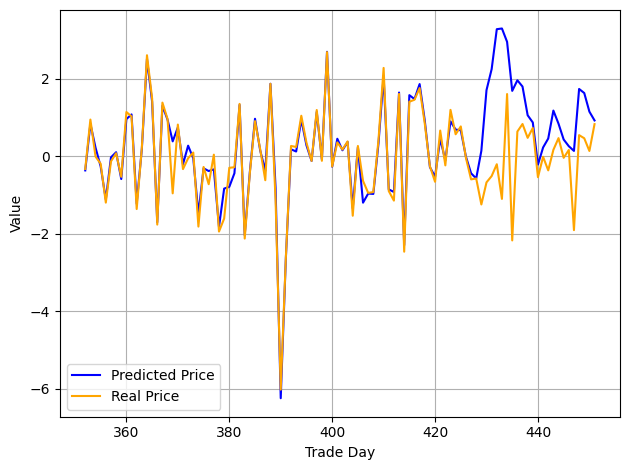

array([[1.        , 0.84710462],
       [0.84710462, 1.        ]])

In [1038]:
y_ref1 = y.squeeze().cpu()
with torch.no_grad():
    y_pred1 = model(X).squeeze().cpu()
visualize(y_pred1, y_ref1, 100)
np.corrcoef(y_pred1, y_ref1)

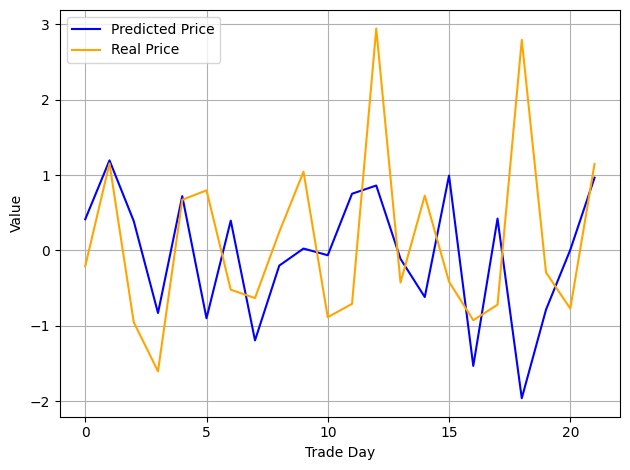

0.04044064129828616

In [1039]:
y_ref2 = y_val.squeeze().cpu()
with torch.no_grad():
    y_pred2 = model(X_val).squeeze().cpu()
visualize(y_pred2, y_ref2)
np.corrcoef(y_pred2, y_ref2)[0, 1]

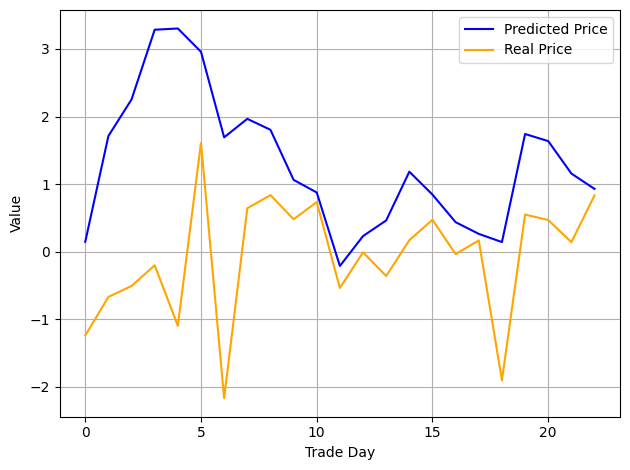

0.1666100614049472

In [1040]:
y_ref3 = y_test.squeeze().cpu()
with torch.no_grad():
    y_pred3 = model(X_test).squeeze().cpu()
visualize(y_pred3, y_ref3)
np.corrcoef(y_pred3, y_ref3)[0, 1]

In [1041]:
pred_delta = y_pred1 * df_gp['delta'].std() + df_gp['delta'].mean()
real_price = df_gp['close'][st:].to_numpy()
real_delta =  df_gp['delta'][st:].to_numpy()
real_price[:10], pred_delta[:10], real_delta[:10]

(array([95.27, 98.12, 96.05, 95.46, 93.68, 97.25, 97.52, 96.32, 97.18,
        99.22]),
 tensor([-0.1477,  2.6067, -1.8438, -0.7613,  1.3232,  3.7111,  0.3272, -1.5854,
          0.5730,  2.3338]),
 array([ 0.18,  2.85, -2.07, -0.59, -1.78,  3.57,  0.27, -1.2 ,  0.86,
         2.04]))

In [1042]:
df_sim = simulate(X, y, real_delta, real_price)

train size:torch.Size([407, 50, 3]), val size: torch.Size([22, 50, 3]), test size: torch.Size([23, 50, 3])
Epoch 999, Train Loss: 0.0431, Val Loss: 1.6363, Test Loss: 0.7714
Epoch 999, Train Loss: 0.0722, Val Loss: 0.6681, Test Loss: 0.7368
Epoch 999, Train Loss: 0.0775, Val Loss: 1.8027, Test Loss: 0.8833
Epoch 999, Train Loss: 0.0875, Val Loss: 0.9177, Test Loss: 0.5485
Epoch 999, Train Loss: 0.0468, Val Loss: 0.5813, Test Loss: 0.4142
Epoch 999, Train Loss: 0.0891, Val Loss: 1.9452, Test Loss: 1.4902
Epoch 999, Train Loss: 0.0632, Val Loss: 0.8522, Test Loss: 1.3666
Epoch 999, Train Loss: 0.0480, Val Loss: 1.3486, Test Loss: 0.6341
Epoch 999, Train Loss: 0.0860, Val Loss: 0.9852, Test Loss: 0.9766
Epoch 999, Train Loss: 0.0416, Val Loss: 0.8609, Test Loss: 1.2661
Epoch 999, Train Loss: 0.0481, Val Loss: 1.0146, Test Loss: 1.8937
Epoch 999, Train Loss: 0.0539, Val Loss: 0.5391, Test Loss: 0.7546
Epoch 999, Train Loss: 0.0576, Val Loss: 0.7117, Test Loss: 1.1180
Epoch 999, Train Loss:

In [1043]:
from google.colab import files
df_sim.to_csv(f"{ticker}_sim.csv", index=False)
files.download(f"{ticker}_sim.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1044]:
np.corrcoef(df_sim['pred_delta_ratio'], df_sim['real_delta_ratio'])

array([[1.        , 0.33328971],
       [0.33328971, 1.        ]])

In [1045]:
np.corrcoef(df_sim['pred_delta'], df_sim['real_delta'])

array([[1.        , 0.33073904],
       [0.33073904, 1.        ]])

In [1046]:
def sigmoid(x, k=1):
    return np.array(1 / (1 + np.exp(-k * x)))

In [1047]:
def arctan(x, k=1):
  return np.array(np.arctan(k * x) / (np.pi / 4))

In [1048]:
def sharpe_ratio(capital, risk_free=0.0):
    returns = np.diff(capital) / capital[:-1]
    excess = np.mean(returns - risk_free)
    std_dev = np.std(returns)
    return (excess / std_dev) * np.sqrt(252)

In [1049]:
def trade(ratios, prices):
    capital = []
    currency = [1.0]
    position = [0.0]
    for ratio, price in zip(ratios[1:], prices[:-1]):
        money = currency[-1] + position[-1] * price
        assert money >= 0, "Bankruptcy"
        capital.append(money)
        nxt_cur = money * (1 - ratio)
        nxt_pos = money * ratio / price
        currency.append(nxt_cur)
        position.append(nxt_pos)
    money = currency[-1] + position[-1] * prices[-1]
    capital.append(money)

    return pd.DataFrame({
        'ratios': ratios,
        'prices': prices,
        'capital': capital,
        'currency': currency,
        'position': position
    })

In [1050]:
annual_risk_free = 0.04
daily_risk_free = (1+annual_risk_free) ** (1/252) - 1
daily_risk_free

0.0001556498627912628

In [1051]:
ratios1, prices1 = np.ones(len(real_price), dtype=float), real_price
df_trade1 = trade(ratios1, prices1)
df_trade1['prices'].iloc[-1] / df_trade1['prices'].iloc[0], df_trade1['capital'].iloc[-1]

(2.003043980266611, 2.003043980266612)

In [1052]:
ratios2, prices2 = sigmoid(pred_delta, 5), real_price
df_trade2 = trade(ratios2, prices2)
df_trade2['prices'].iloc[-1] / df_trade2['prices'].iloc[0], df_trade2['capital'].iloc[-1]

(2.003043980266611, 21.430361292693988)

In [1053]:
ratios3, prices3 = arctan(pred_delta, 1), real_price
df_trade3 = trade(ratios3, prices3)
df_trade3['prices'].iloc[-1] / df_trade3['prices'].iloc[0], df_trade3['capital'].iloc[-1]

(2.003043980266611, 2656.4025311988635)

In [1054]:
ma50 = df_gp['50_ma'][st:].to_numpy()
ma200 = df_gp['200_ma'][st:].to_numpy()
ratios4, prices4 = (ma50 >= ma200).astype(int), real_price
df_trade4 = trade(ratios4, prices4)
df_trade4['prices'].iloc[-1] / df_trade4['prices'].iloc[0], df_trade4['capital'].iloc[-1]

(2.003043980266611, 1.9921703726902598)

In [1055]:
ratios5, prices5 = sigmoid(df_sim['pred_delta'], 5), real_price
df_trade5 = trade(ratios5, prices5)
df_trade5['prices'].iloc[-1] / df_trade5['prices'].iloc[0], df_trade5['capital'].iloc[-1]

(2.003043980266611, 4.451961034273296)

In [1056]:
ratios6, prices6 = arctan(df_sim['pred_delta'], 1), real_price
df_trade6 = trade(ratios6, prices6)
df_trade6['prices'].iloc[-1] / df_trade6['prices'].iloc[0], df_trade6['capital'].iloc[-1]

(2.003043980266611, 19.08929331152316)

In [1057]:
print(f"Always hold stock: (Sharpe){sharpe_ratio(df_trade1['capital'], daily_risk_free):.2f}, (Yield){df_trade1['capital'].iloc[-1]:.2f}")
print(f"Simple long-short term strategy: (Sharpe){sharpe_ratio(df_trade4['capital'], daily_risk_free):.2f}, (Yield){df_trade4['capital'].iloc[-1]:.2f}")
print(f"Our strategy (no short selling): (Sharpe){sharpe_ratio(df_trade5['capital'], daily_risk_free):.2f}, (Yield){df_trade5['capital'].iloc[-1]:.2f}")
print(f"Our strategy (short selling): (Sharpe){sharpe_ratio(df_trade6['capital'], daily_risk_free):.2f}, (Yield){df_trade6['capital'].iloc[-1]:.2f}")

Always hold stock: (Sharpe)1.31, (Yield)2.00
Simple long-short term strategy: (Sharpe)1.38, (Yield)1.99
Our strategy (no short selling): (Sharpe)3.74, (Yield)4.45
Our strategy (short selling): (Sharpe)4.61, (Yield)19.09
